In [1]:
import vtk
from vtk.util import numpy_support
import os
import numpy
from matplotlib import pyplot, cm
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [24]:
PathDicom = "/home/intern/Downloads/PCsub1-20090909/W0001/1.2.826.0.1.3680043.2.656.1.136/S02A01/"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

In [25]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

In [26]:
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [27]:


# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')



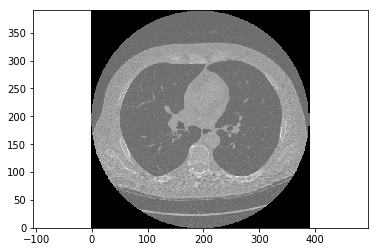

In [28]:
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, numpy.flipud(numpy.rot90(ArrayDicom[:, :, 115])))

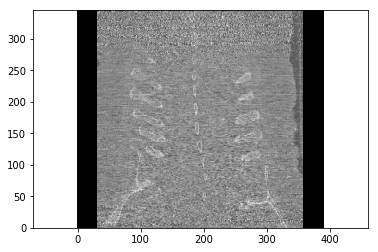

In [29]:


pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, z, numpy.flipud(numpy.rot90(ArrayDicom[:, 115, :])))



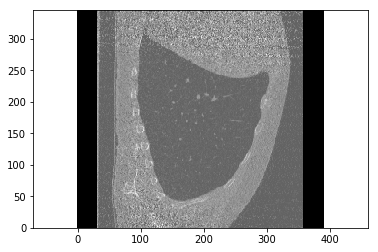

In [30]:
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(y,z , numpy.flipud(numpy.rot90(ArrayDicom[115, :, :])))
